# Import everything needed for MORO

In [3]:
from ema_workbench import (Model, RealParameter, Policy, Constant, Scenario, ScalarOutcome)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import (MultiprocessingEvaluator, ema_logging, perform_experiments) # parallel computing

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  
# With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.


ema_logging.log_to_stderr(ema_logging.INFO)

'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''

dike_model, planning_steps = get_model_for_problem_formulation(1) # assign problem_formulation_id


In [12]:
# for levers in dike_model.levers:
#     print(levers)

# Define the robustness metrics

In [79]:
import functools

# percentile90 = functools.partial(np.percentile, q=90)

# def var_mean(data):
#     return ((np.percentile(data,q=75)-np.percentile(data,q=25))*np.sum(data)/(data.shape[0]))

def mean_rob(data):
    return np.sum(data)/(data.shape[0]*1e9)

def threshold(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'
investment_thres = functools.partial(threshold, SMALLER, 150000000)

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE 

robustness_functions = [ScalarOutcome('Expected Number of Deaths', kind=MINIMIZE,
                             variable_name='Expected Number of Deaths', function=percentile90),
                        ScalarOutcome('Expected Annual Damage', kind=MINIMIZE,
                             variable_name='Expected Annual Damage', function=var_mean),
                       ScalarOutcome('Total Investment Costs', kind=MINIMIZE,
                             variable_name='Total Investment Costs', function=investment_thres),]

# Expected Annual Damage
# RfR Investment Costs
# Evacuation Costs
# Expected Number of Deaths
# Total Investment Costs

# Check the number of needed scenarios

In [5]:
%%time 
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=400,               
                                            policies=6)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 400 scenarios * 6 policies * 1 model(s) = 2400 experiments
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 480 cases completed
[MainProcess/INFO] 720 cases completed
[MainProcess/INFO] 960 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1440 cases completed
[MainProcess/INFO] 1680 cases completed
[MainProcess/INFO] 1920 cases completed
[MainProcess/INFO] 2160 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Wall time: 15min 35s


In [6]:
save_results(results, "perform_experiments400scen6pol.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\perform_experiments400scen6pol.tar.gz


In [7]:
results = load_results(".\perform_experiments400scen6pol.tar.gz")
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Documents\GitHub\MBDM-group-11\perform_experiments400scen6pol.tar.gz


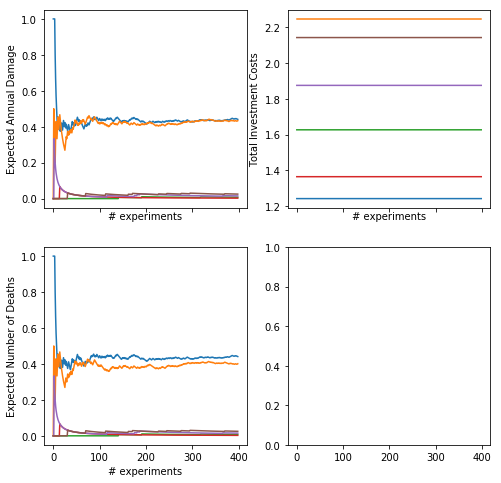

In [77]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

SMALLER = 'SMALLER'
robustness_funcs = {"Expected Number of Deaths": functools.partial(threshold, SMALLER, 0.00001),
                    "Expected Annual Damage": functools.partial(threshold, SMALLER, 100000), 
                    "Total Investment Costs": mean_rob }


for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

In [ ]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

BaseEvaluator.reporting_frequency = 0.1

ema_logging.log_to_stderr(ema_logging.INFO)

# there is a bit of problem with platypus, so using 1.1. gives 
# cleaner hypervolume results.
convergence = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 1.1]),
              EpsilonProgress()]

nfe = 50

epsilon = [0.0001, 0.002, 0.0001]


convergence_metrics = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 3, 1.1]),
                       EpsilonProgress()]

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios,nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons)
 
%%time 
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios,
                            nfe=nfe, convergence=convergence_metrics, epsilons=epsilon)
#start = time.time()